# Proper Orthogonal Decomposition (POD)

In [1]:
import os
import numpy as np
import warnings
warnings.simplefilter('ignore')

os.chdir('../')
from lib.methods import *


os.chdir('../')

2023-05-07 13:26:44.033340: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
class MRI8_NVF4_10mm_0p2mmVVV:
    CSV_FILE_DIR = './data/VF_FVF_DATASETS/CSV/'
    VIDEO_FILE_DIR = './data/VF_FVF_DATASETS/VIDEO/'
    DATA_NAME = 'MRI8_NVF4_10mm_0p2mmVVV'
    SAMPLE_SPAN = [150000, 170000]
    FILTERING_CSV_METHODS = 'bandpass_filtering'
    BANDPASS_FILTERING_PARAMS = {
                    'passband_edge_freq':[100, 350], 
                    'stopband_edge_freq':[20, 800], 
                    'passband_edge_max_loss':1, 
                    'stopband_edge_min_loss':40
                    }
    LINE_SCANNING_PARAMS_VF = {'position':[50, 40],'width': 40}
    LINE_SCANNING_PARAMS_FVF = {'position':[70, 80],'width': 70}
    FILTERING_VIDEO_PARAMS_VF = {'kernel_length':10, 'kernel_size':1}
    FILTERING_VIDEO_PARAMS_FVF = {'kernel_length':10, 'kernel_size':1}
    CUT_PARAMS = [5000, -5000]

cfg = MRI8_NVF4_10mm_0p2mmVVV

## Load data

In [3]:
csv_data_list, video_data_list, video_t_data_list = LoadCSVandVIDEOS(
                                                                    csv_path=cfg.CSV_FILE_DIR+cfg.DATA_NAME+'.csv', 
                                                                    data_name_list=['t', 'mic'], 
                                                                    sample_span=cfg.SAMPLE_SPAN, 
                                                                    videos_path_list=[
                                                                                    cfg.VIDEO_FILE_DIR+'VF/'+cfg.DATA_NAME+'.avi',
                                                                                    cfg.VIDEO_FILE_DIR+'FVF/'+cfg.DATA_NAME+'.avi',
                                                                                    ]
                                                                    )

mic_t_data = csv_data_list[0]
mic_data = csv_data_list[1]

Loading csv data
file path | ./data/VF_FVF_DATASETS/CSV/MRI8_NVF4_10mm_0p2mmVVV.csv
data list | t, mic
Loading video data
file path | ./data/VF_FVF_DATASETS/VIDEO/VF/MRI8_NVF4_10mm_0p2mmVVV.avi


Loading video data
file path | ./data/VF_FVF_DATASETS/VIDEO/FVF/MRI8_NVF4_10mm_0p2mmVVV.avi


## Pre-processing

In [52]:
PP = PreProcessing(
                data=mic_data,
                t_data=mic_t_data,
                video_data_list=video_data_list, 
                video_t_data_list=video_t_data_list
                )
PP.filter(
        method=cfg.FILTERING_CSV_METHODS, 
        params=cfg.BANDPASS_FILTERING_PARAMS
        )
#PP.filter_video(params_list=[
                       #cfg.FILTERING_VIDEO_PARAMS_VF, 
                        #cfg.FILTERING_VIDEO_PARAMS_FVF
                        #])
PP.cut(sample_span=cfg.CUT_PARAMS)

mic_data_pp = PP.data
mic_t_data_pp = PP.t_data
video_vf_data_pp =  PP.video_data_list[0]
video_fvf_data_pp =  PP.video_data_list[1]
video_vf_t_data_pp = PP.video_t_data_list[0]
video_fvf_t_data_pp = PP.video_t_data_list[1]

## POD

In [25]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

class Standardization:
    def __init__(self, data):
        self.SS = StandardScaler()
        self.X = data

    def transform(self):
        X_std = self.SS.fit_transform(self.X)
        return X_std
    
    def inverse_transform(self, data_std):
        X_rec = self.SS.inverse_transform(data_std)
        return X_rec

class Normalization:
    def __init__(self, data):
        self.MMS = MinMaxScaler()
        self.X = data

    def transform(self):
        X_nl = self.MMS.fit_transform(self.X)
        return X_nl
    
    def inverse_transform(self, data_nl):
        X_rec = self.MMS.inverse_transform(data_nl)
        return X_rec


class ProperOrthogonalDecomposition:
    def __init__(self, data, normalization=True, standardization=False):
        self.X = data
        self.Xis3D = False
        self.normalization = normalization
        self.standardization = standardization


        ### If original X's dimension is 3D, it reshapes 3D to 2D.
        if self.X.ndim==3:
            self.Xis3D = True
            self.Xshape = self.X.shape
            self.X = self.X.reshape(self.Xshape[0], self.Xshape[1]*self.Xshape[2])

        ### Normalization
        if self.normalization:
            self.NL = Normalization(self.X)
            self.X = self.NL.transform()

        ### Standardization
        if self.standardization:
            self.STD = Standardization(self.X)
            self.X = self.STD.transform()

    def fit(self, method='ED'):
        self.X_mean = np.mean(self.X, axis=0)
        self.n_samples, self.n_features = self.X.shape
        
        ### Eigen Decomposition (ED)
        if method=='ED':
            ### Covariance matrix
            self.C = np.cov((self.X - self.X_mean).T)
            ### Eigenvalue problem (Eigenvalue　matrix: lam, Eigenvector matrix: phi)
            lam, phi = np.linalg.eig(self.C) ### Solution of "C @ phi = lam @ phi"
            self.lam = lam[np.argsort(lam)[::-1]] ### Sort descending
            self.phi = np.real(phi[:, np.argsort(lam)[::-1]]) ### Sort descending

        ### Singular Value Decomposition (SVD)
        if method=='SVD':
            ### SVD
            U, S, V = np.linalg.svd((self.X - self.X_mean), full_matrices=False)
            self.Sigma = S
            self.VT = V.T
            ### Compute Eigenvalue and Eigenvector
            self.lam = self.Sigma**2 / (self.n_samples-1)
            self.phi = self.VT

        ### Contribution rate
        self.lam_rate = self.lam/np.sum(self.lam)
        self.lam_rate_cumsum = np.cumsum(self.lam)/np.sum(self.lam) ### Cumulative sum

    def transform(self, data, n_components=1, savgol_filter=True, savgol_params={'window_length':51, 'polyorder':3}):
        X = data
        r = n_components

        ### If original X's dimension is 3D, it reshapes 3D to 2D.
        if X.ndim==3:
            Xshape = X.shape
            X = X.reshape(Xshape[0], Xshape[1]*Xshape[2])

        ### Normalization
        if self.normalization:
            self.NL_xform = Normalization(X)
            X = self.NL_xform.transform()

        ### Standardization
        if self.standardization:
            self.STD_xform = Standardization(X)
            X = self.STD_xform.transform()

        self.X_mean_xform = np.mean(X, axis=0)

        ### Transform
        r = n_components
        Y = (X - self.X_mean_xform) @ self.phi[:, :r]

        ### Savgol filtering
        if savgol_filter:
            Y = savgol_filtering(Y, window_length=savgol_params['window_length'], polyorder=savgol_params['polyorder'])

        return Y
    
    def inverse_transform(self, data, recovering=True, recovering_conditions='fit'):
        Y = data
        r = data.shape[1]

        ### Inverse transform
        X_rec = Y[:, :r] @ self.phi[:, :r].T

        ### Recovering
        if recovering:
            ### Conditions (fit's or transforms's)
            if recovering_conditions=='fit':
                X_mean = self.X_mean
                if self.normalization:
                    NL = self.NL
                if self.standardization:
                    STD = self.STD
            if recovering_conditions=='transform':
                X_mean = self.X_mean_xform
                if self.normalization:
                    NL = self.NL_xform
                if self.standardization:
                    STD = self.STD_xform
            ### Recovering zero-mean
            X_rec = X_rec + X_mean
            ### Recovering normalization
            if self.normalization:
                X_rec = NL.inverse_transform(X_rec)
            ### Recovering standardization
            if self.standardization:
                X_rec = STD.inverse_transform(X_rec)

        ### If original X's dimension is 3D, X_rec reshapes 2D to 3D.
        if self.Xis3D:
            X_rec = X_rec.reshape(X_rec.shape[0], self.Xshape[1], self.Xshape[2])

        return X_rec
    
    def get_mode_eigenvector(self, mode_num):
        mode_eigenvector = self.phi[:, mode_num]
        if self.Xis3D:
            mode_eigenvector = mode_eigenvector.reshape(self.Xshape[1], self.Xshape[2])
        return mode_eigenvector
    
    def get_mode_dynamics(self, modes_component, mode_num):
        mode_dynamics = modes_component.reshape(-1, 1) @ self.phi[:, mode_num].reshape(-1, 1).T
        if self.Xis3D:
            mode_dynamics = mode_dynamics.reshape(mode_dynamics.shape[0], self.Xshape[1], self.Xshape[2])
        return mode_dynamics


In [53]:
POD = ProperOrthogonalDecomposition(data=video_vf_data_pp,
                                    normalization=True, standardization=False)

POD.fit(method='ED')

In [54]:
principal_components_vf = POD.transform(data=video_vf_data_pp, n_components=10, 
                                        savgol_filter=True, savgol_params={'window_length':51, 'polyorder':3})

In [182]:
import matplotlib.pylab as plt
from matplotlib import gridspec

class Figure():

    def __init__(self, rcParams_dict):
        for key in rcParams_dict.keys():
            plt.rcParams[str(key)] = rcParams_dict[str(key)]      

    def timeseries(self, 
                data, t, start=0, stop=None,
                figsize=(20, 5), linestyle='-', c='k', lw='3',
                title=None, title_loc='center', 
                xlabel='Time', ylabel=r'$x(t)$',
                save_png=None, save_eps=None):
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot()
        ax.set_title(title, loc=title_loc)
        ax.plot(t[start:stop], data[start:stop], linestyle=linestyle, c=c, lw=lw)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        plt.tight_layout()
        if save_png==None:
            plt.show()
        else:
            plt.savefig(save_png+'.png', bbox_inches="tight")
        if save_png==None:
            return
        else:
            plt.savefig(save_eps+'.eps', bbox_inches="tight")
    
    def power_spectra(self, 
                data, t, freq_lim=(0, 600),
                figsize=(8, 5), linestyle='-', c='k', lw='3',
                title=None, title_loc='center', 
                xlabel='Frequency [Hz]', ylabel='Power Spectral',
                save_png=None, save_eps=None):
        freq_data, amp_data = fft(data, t)
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot()
        ax.set_title(title, loc=title_loc)
        ax.plot(freq_data, amp_data, linestyle=linestyle, lw=lw, c=c)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_xlim(freq_lim)
        plt.tight_layout()
        if save_png==None:
            plt.show()
        else:
            plt.savefig(save_png+'.png', bbox_inches="tight")
        if save_png==None:
            return
        else:
            plt.savefig(save_eps+'.eps', bbox_inches="tight")

    def mode_eigenvector(self,
                        data, 
                        figsize=(5, 5), aspect=1, title=None, title_loc='left',
                        cmap='seismic', cbar=True, cbar_label='Eigenvector '+r'$\phi_i$',
                        save_png=None, save_eps=None
                        ):
        image_max = np.abs(np.max(data))
        image_min = np.abs(np.min(data))
        image_range = max(image_max, image_min)
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot()
        ax.set_title(title, loc=title_loc)
        image = ax.imshow(data, cmap=cmap, vmin=-image_range, vmax=image_range, aspect=aspect)
        ax.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
        if cbar:
            colorbar = fig.colorbar(image)
            colorbar.set_label(cbar_label)
        plt.tight_layout()
        if save_png==None:
            plt.show()
        else:
            plt.savefig(save_png+'.png', bbox_inches="tight")
        if save_png==None:
            return
        else:
            plt.savefig(save_eps+'.eps', bbox_inches="tight")

    def mode_analysis(self,
                      eigenvector, component, t, 
                      figsize=(5, 5), width_ratios=[1, 2, 1.5], wspace=0.1,
                      title0=None, title1=None, title2=None, 
                      title_loc0=None, title_loc1=None, title_loc2=None, 
                      aspect=1, cmap='seismic', cbar=True, cbar_label='Eigenvector '+r'$\phi_i$',
                      start=0, stop=None, linestyle1='-', c1='k', lw1=3, xlabel1='Time', ylabel1=r'$y_1(t)$',
                      linestyle2='-', c2='k', lw2=3, xlabel2='Frequency [Hz]', ylabel2='Power Spectral', freq_lim=(0, 600),
                      save_png=None, save_eps=None
                      ):
        spec = gridspec.GridSpec(ncols=3, nrows=1, width_ratios=width_ratios, wspace=wspace)
        fig = plt.figure(figsize=figsize)

        ax0 = fig.add_subplot(spec[0])
        image_range = max(np.abs(np.max(eigenvector)), np.abs(np.min(eigenvector)))
        ax0.set_title(title0, loc=title_loc0)
        image = ax0.imshow(eigenvector, cmap=cmap, vmin=-image_range, vmax=image_range, aspect=aspect)
        ax0.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
        if cbar:
            colorbar = fig.colorbar(image, location = 'left')
            colorbar.set_label(cbar_label)

        ax1 = fig.add_subplot(spec[1])
        ax1.set_title(title1, loc=title_loc1)
        ax1.plot(t[start:stop], component[start:stop], linestyle=linestyle1, c=c1, lw=lw1)
        ax1.set_xlabel(xlabel1)
        ax1.set_ylabel(ylabel1)

        ax2 = fig.add_subplot(spec[2])
        freq_data, amp_data = fft(component, t)
        ax2.set_title(title2, loc=title_loc2)
        ax2.plot(freq_data, amp_data, linestyle=linestyle2, lw=lw2, c=c2)
        ax2.set_xlabel(xlabel2)
        ax2.set_ylabel(ylabel2)
        ax2.set_xlim(freq_lim)

        plt.tight_layout()
        if save_png==None:
            plt.show()
        else:
            plt.savefig(save_png+'.png', bbox_inches="tight")
        if save_png==None:
            return
        else:
            plt.savefig(save_eps+'.eps', bbox_inches="tight")

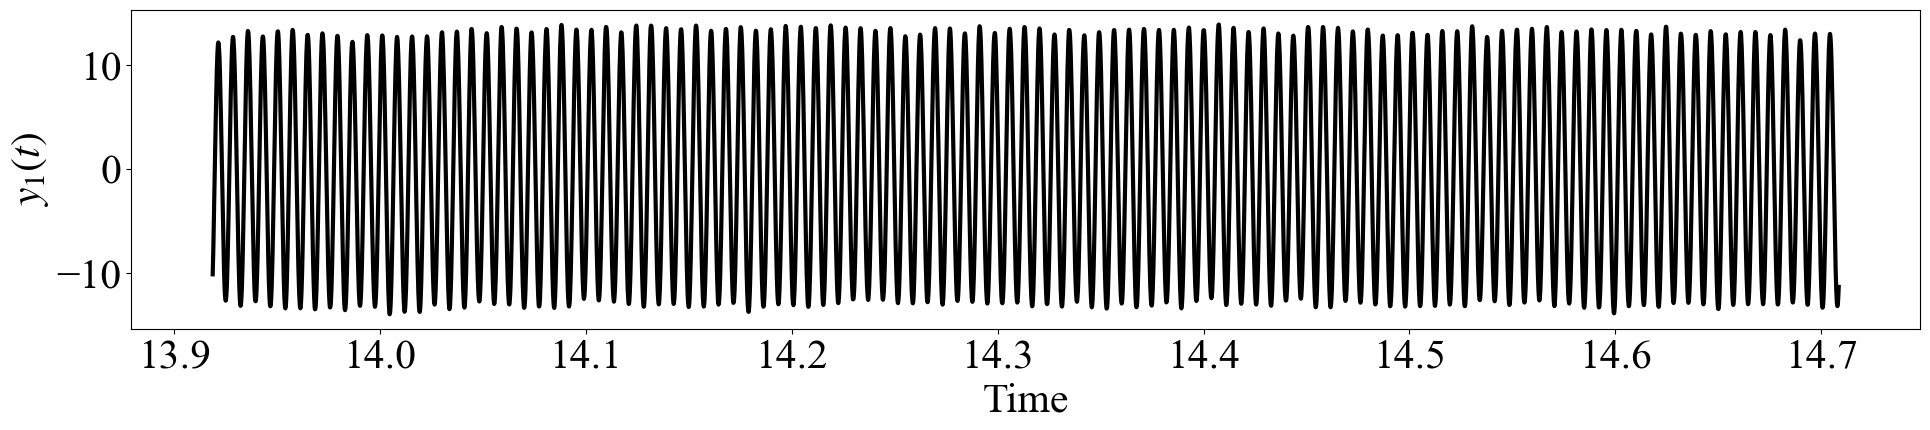

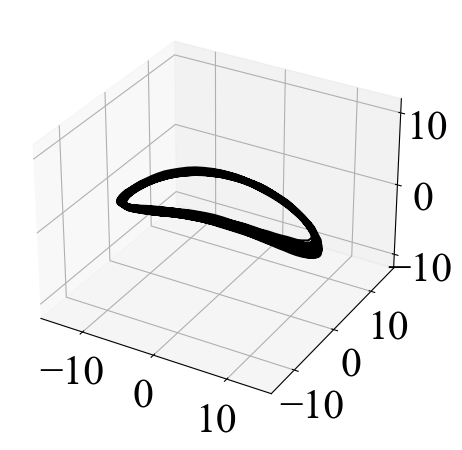

In [55]:
fig = Figure({
            'font.family':'Times New Roman',
            'mathtext.fontset':'stix',
            'font.size':30,
            })

fig.timeseries(data=principal_components_vf[:, 0], t=video_vf_t_data_pp, start=50, stop=-50,
                figsize=(20, 5), linestyle='-', c='k', lw='3',
                title=None, title_loc='center', 
                xlabel='Time', ylabel=r'$y_1(t)$',
                save_png=None, save_eps=None)

fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(projection='3d')
ax.plot(principal_components_vf[50:-50, 0], principal_components_vf[50:-50, 1], principal_components_vf[50:-50, 2], c='k')
ax.set_aspect('equal', 'datalim')
plt.tight_layout()
plt.show()

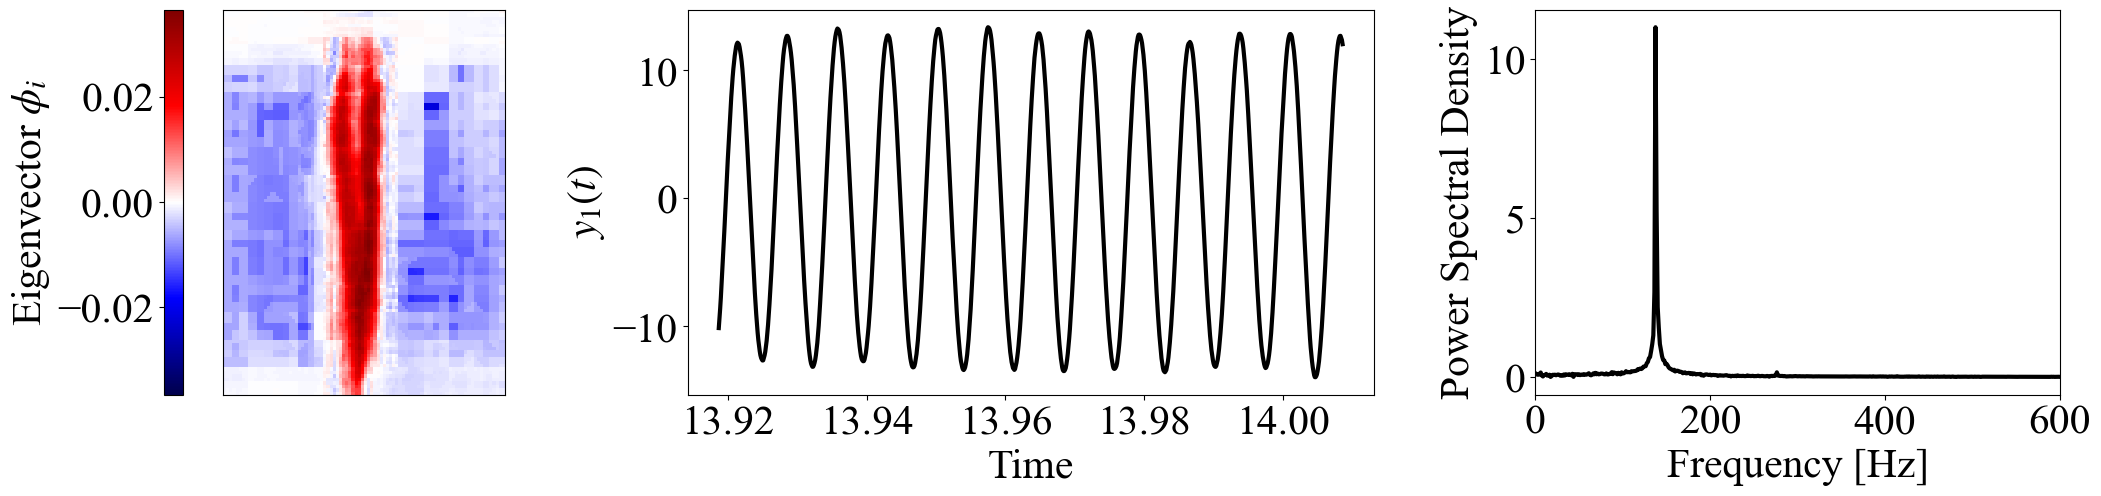

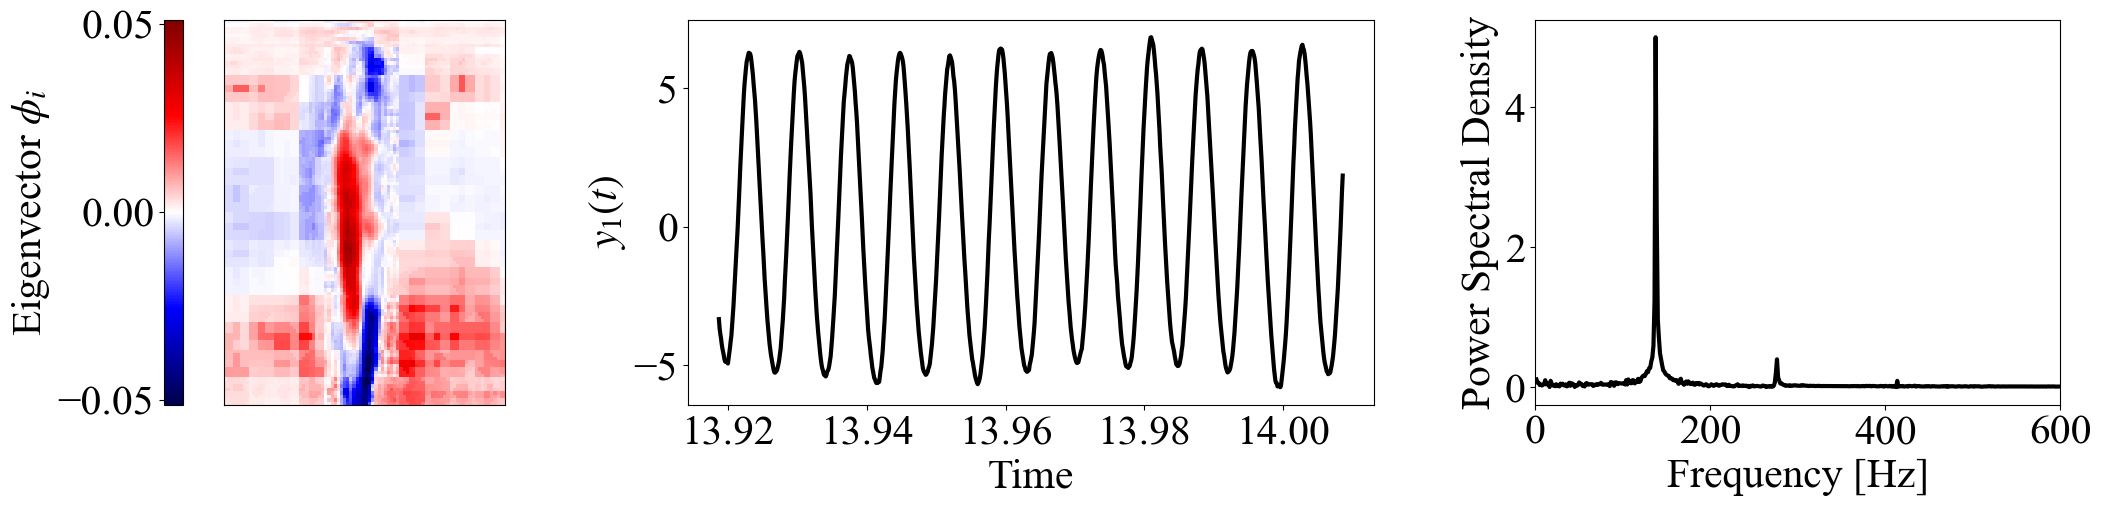

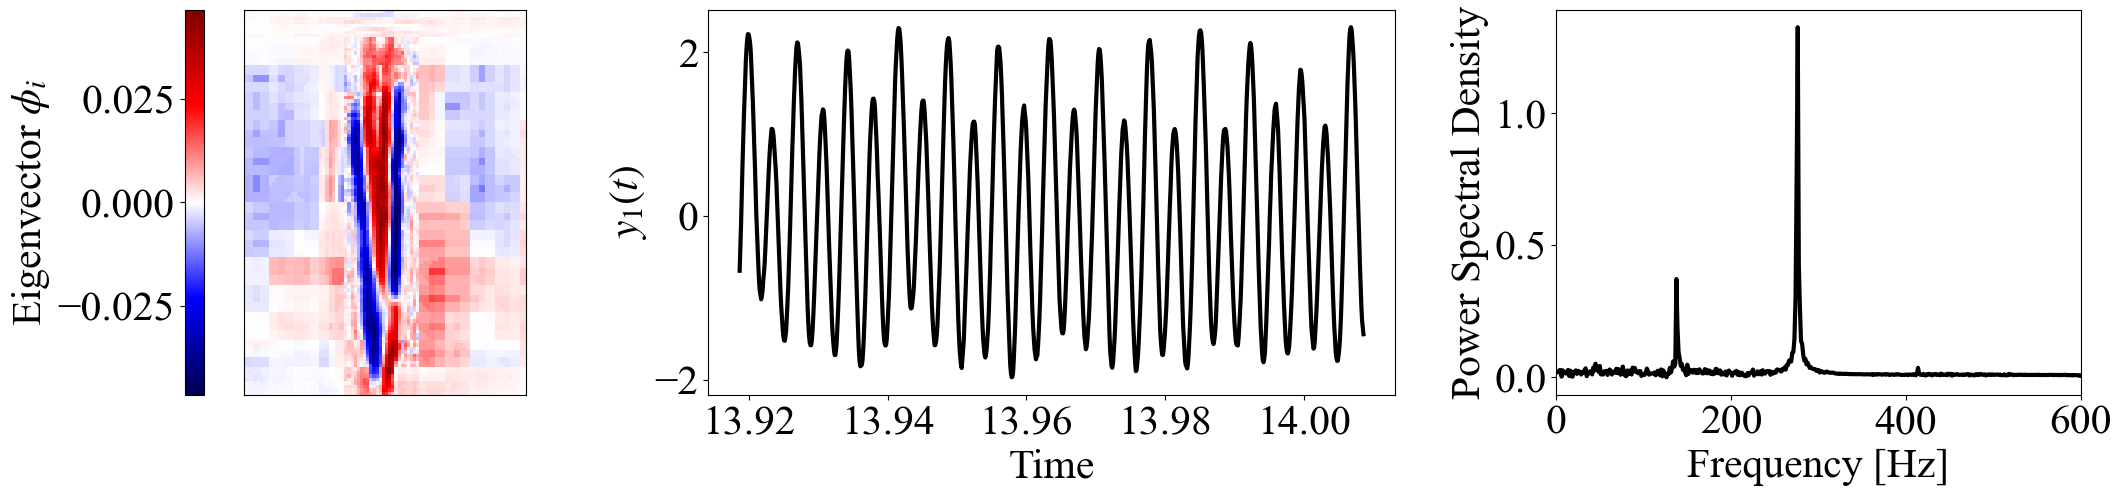

In [197]:
fig = Figure({
            'font.family':'Times New Roman',
            'mathtext.fontset':'stix',
            'font.size':30,
            })

mode=0

mode_eigenvector = POD.get_mode_eigenvector(mode_num=mode)

fig.mode_analysis(eigenvector=mode_eigenvector, component=principal_components_vf[:, mode], t=video_vf_t_data_pp, 
                figsize=(25, 5), width_ratios=[1, 1.7, 1.3], wspace=0.3,
                title0=None, title1=None, title2=None, 
                title_loc0=None, title_loc1=None, title_loc2=None, 
                aspect=1.1, cmap='seismic', cbar=True, cbar_label='Eigenvector '+r'$\phi_i$',
                start=50, stop=950, linestyle1='-', c1='k', lw1=3, xlabel1='Time', ylabel1=r'$y_1(t)$',
                linestyle2='-', c2='k', lw2=3, xlabel2='Frequency [Hz]', ylabel2='Power Spectral Density', freq_lim=(0, 600),
                save_png=None, save_eps=None
                )

mode=1

mode_eigenvector = POD.get_mode_eigenvector(mode_num=mode)

fig.mode_analysis(eigenvector=mode_eigenvector, component=principal_components_vf[:, mode], t=video_vf_t_data_pp, 
                figsize=(25, 5), width_ratios=[1, 1.7, 1.3], wspace=0.3,
                title0=None, title1=None, title2=None, 
                title_loc0=None, title_loc1=None, title_loc2=None, 
                aspect=1.1, cmap='seismic', cbar=True, cbar_label='Eigenvector '+r'$\phi_i$',
                start=50, stop=950, linestyle1='-', c1='k', lw1=3, xlabel1='Time', ylabel1=r'$y_1(t)$',
                linestyle2='-', c2='k', lw2=3, xlabel2='Frequency [Hz]', ylabel2='Power Spectral Density', freq_lim=(0, 600),
                save_png=None, save_eps=None
                )

mode=2

mode_eigenvector = POD.get_mode_eigenvector(mode_num=mode)

fig.mode_analysis(eigenvector=mode_eigenvector, component=principal_components_vf[:, mode], t=video_vf_t_data_pp, 
                figsize=(25, 5), width_ratios=[1, 1.7, 1.3], wspace=0.3,
                title0=None, title1=None, title2=None, 
                title_loc0=None, title_loc1=None, title_loc2=None, 
                aspect=1.1, cmap='seismic', cbar=True, cbar_label='Eigenvector '+r'$\phi_i$',
                start=50, stop=950, linestyle1='-', c1='k', lw1=3, xlabel1='Time', ylabel1=r'$y_1(t)$',
                linestyle2='-', c2='k', lw2=3, xlabel2='Frequency [Hz]', ylabel2='Power Spectral Density', freq_lim=(0, 600),
                save_png=None, save_eps=None
                )

In [60]:
video_vf_data_rec = POD.inverse_transform(data=principal_components_vf[:, :10], 
                                          recovering=True, recovering_conditions='fit')

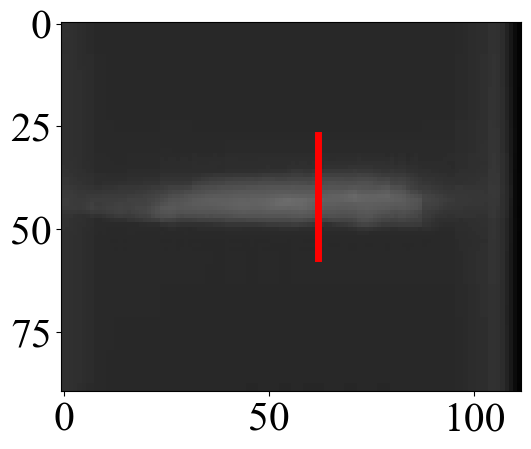

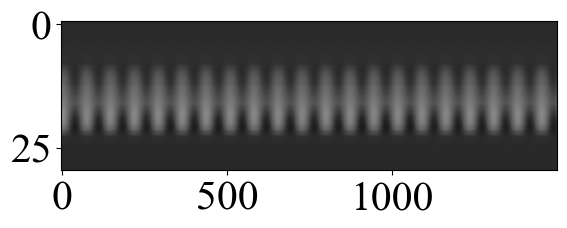

In [59]:
from matplotlib.colors import Normalize

image = video_vf_data_rec

position = [42, 50]
width = 30

x = image.shape[1]
y = image.shape[2]
a = position[0]
b = position[1]

plt.imshow(np.rot90(image[1000], -1), cmap='Greys_r', norm=Normalize(vmin=0, vmax=255))
plt.plot([x-b, x-b], [a-int(width/2), a+int(width/2)], color='r', linewidth=5)
plt.show()

linescanned = line_scanning(image, position, width)
plt.imshow(linescanned[:1500].T, cmap='Greys_r', aspect=15, norm=Normalize(vmin=0, vmax=255))
plt.show()

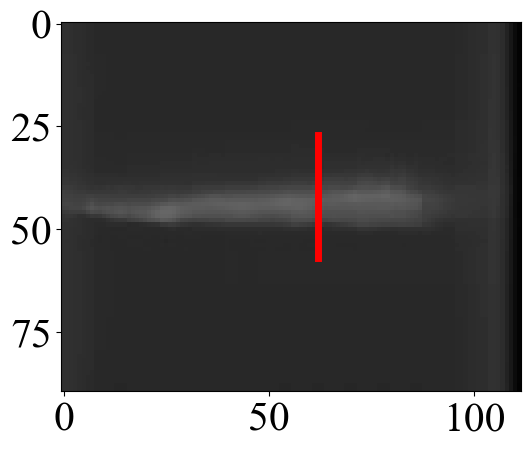

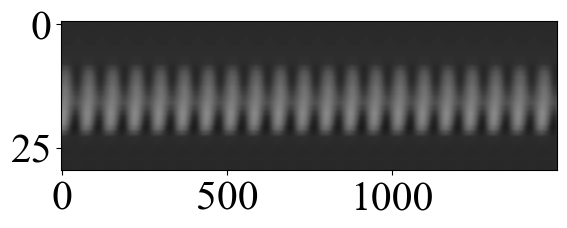

In [57]:
from matplotlib.colors import Normalize

image = video_vf_data_rec

position = [42, 50]
width = 30

x = image.shape[1]
y = image.shape[2]
a = position[0]
b = position[1]

plt.imshow(np.rot90(image[1000], -1), cmap='Greys_r', norm=Normalize(vmin=0, vmax=255))
plt.plot([x-b, x-b], [a-int(width/2), a+int(width/2)], color='r', linewidth=5)
plt.show()

linescanned = line_scanning(image, position, width)
plt.imshow(linescanned[:1500].T, cmap='Greys_r', aspect=15, norm=Normalize(vmin=0, vmax=255))
plt.show()

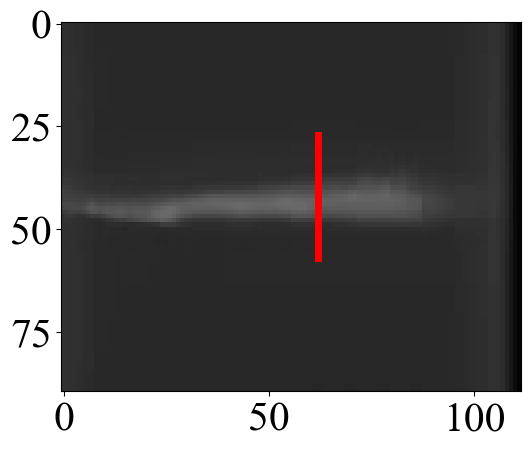

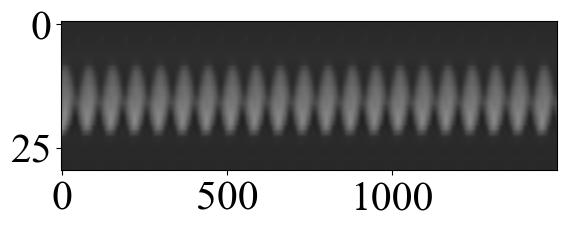

In [61]:
from matplotlib.colors import Normalize

image = video_vf_data_rec

position = [42, 50]
width = 30

x = image.shape[1]
y = image.shape[2]
a = position[0]
b = position[1]

plt.imshow(np.rot90(image[1000], -1), cmap='Greys_r', norm=Normalize(vmin=0, vmax=255))
plt.plot([x-b, x-b], [a-int(width/2), a+int(width/2)], color='r', linewidth=5)
plt.show()

linescanned = line_scanning(image, position, width)
plt.imshow(linescanned[:1500].T, cmap='Greys_r', aspect=15, norm=Normalize(vmin=0, vmax=255))
plt.show()